<a href="https://colab.research.google.com/github/SERVIR-Amazonia/MANGLEE/blob/main/EN_SP_Manglee_M1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

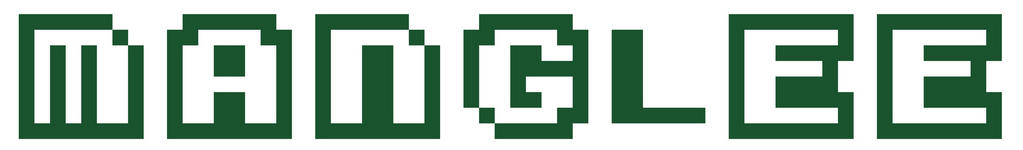


---




**MODULO 1 : CREAR UN COMPUESTO TEMPORAL SENTINEL-2 LEVEL 2A BOA (S2 L2A)**

*MODULE 1 : TO CREATE A S2 L2A COMPOSITE*

---
El Modulo 1 crea  un compuesto temporal con datos ópticos Sentinel 2 nivel 2A, aplica una máscara de nubes y sombras, y calcula varios índices de vegetación.

*Module 1 creates a temporal composite with S2 data, applied a cloud and shadow mask and calculated index vegetations*

## Requisitos
*Requirements*
* Cuenta Google Colab  
 *Account Google Colab*
* Cuenta en Google Earth Engine https://code.earthengine.google.com/register

  *Account in Google Earth Engine*

* Archivo vectorial shapefile de la zona de estudio

  *Shapefile with the polygon of the study area*

**Este archivo debe estar cargado en GEE como Asset**
## Recomendación:
* Si quieres guardar los cambios crea una copia de este notebook en tu Drive

* *If you want to save the changes, create a copy of this notebook*

Este código ha sido adaptado por Lorena Caiza (ECOCIENCIA/SERVIR-Amazonia/CAMBIUM UVa) a partir del código de jdbcode publicado en Google Earth Engine Developers.
Ultima modificación 15/05/2023

Documentos, difusión y resultados los encontrarás aquí:
https://sites.google.com/view/mangleetrain/inicio

Licensed under a Creative Commons Attribution 4.0 license. (CC-BY).

**Como cargar un shapefile en GEE**

*How to upload a shafile in GEE*

Go to the Code Editor de GEE and clic in Assets


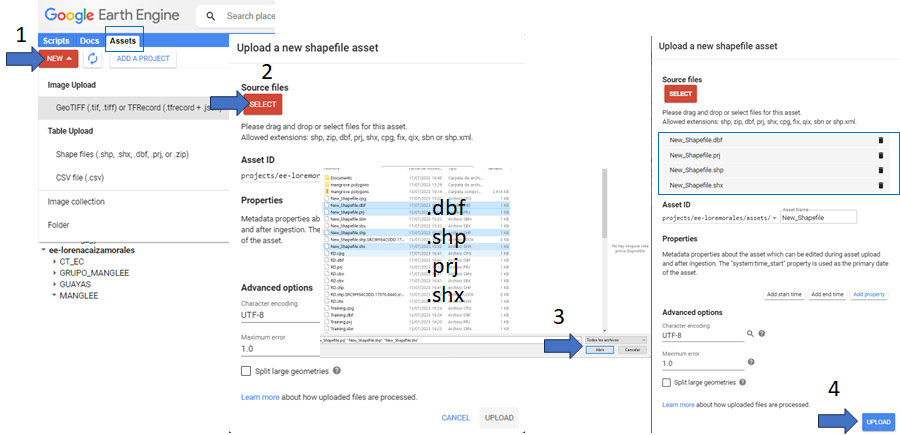

Para ejecutar el código clic en el botón play ubicado en el margen izquierdo de cada sección o utiliza Crtl + Enter

*Running MANGLEE*

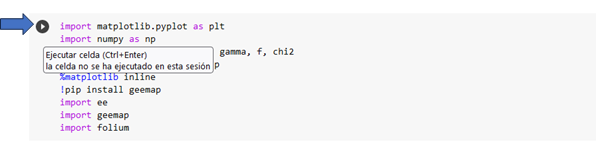

##RUNNING MANGLEE
### Cargar librerías
*Import libraries*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline
!pip install geemap
import ee
import geemap
import folium

### Activar la cuenta de Google Earth Engine
*Active GEE account*
1. Clic link

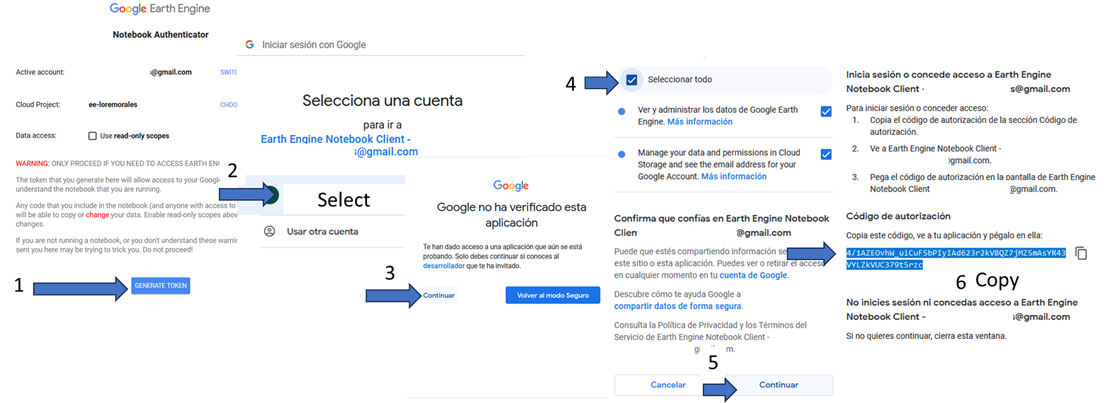

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=VOWmAAyzT8tjk9YL82JnLz9k3Lhe9wPNU0pIKalJRIw&tc=D_3A8lHSiqLZhWQAJRRzk-fXN-AsuqkHXaMAKDL7Lqk&cc=iGG_rWVq1HZ5FVr0wIWQ53rAipRP-bHZqCWWrU0mni8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AZEOvhW_uiCuFSbPIyIAd623r2kVBQZ7jMZ5mAsYR43VYLZkVUC379t5rzc

Successfully saved authorization token.


### Introducir el área de estudio y las fechas de análisis
*Introduce your study area and data period of analysis*

En AOI cargar la dirección del Asset (assetID) la puede encontrar en los datos del archivo dentro del su repositorio de GEE

*Introduce the assetID*

##¿Donde encuentro el assetID en GEE?
*Where is the AssetID?*


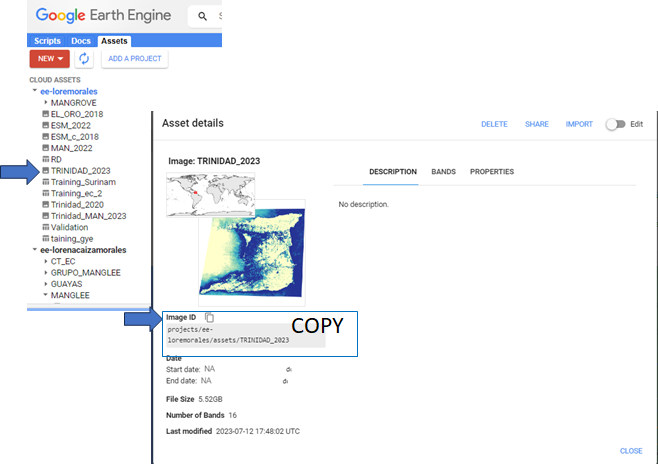

In [ ]:
##Reemplaza tu zona de estudio en el paréntesis
AOI =ee.FeatureCollection('projects/ee-lorenacaizamorales/assets/GRUPO_MANGLEE/ESM') ##Change
##Definir el rango de fechas de los productos Sentinel 2
START_DATE= ee.Date('2020-03-01') ##Change
END_DATE= ee.Date('2020-12-31')  ##Change
##Variables de nubosidad
CLOUD_FILTER = 100
CLD_PRB_THRESH = 30
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 40

### Función para filtrar los datos Sentinel 2
*Function to filter S2 data*

In [ ]:
def s2_cld(aoi, start_date, end_date):
     # Importar y filtrar la colección Sentinel 2 nivel 2A
     s2_sr_col = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .filterBounds(AOI)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
     # Importar y filtrar por probabilidad de nubosidad (S2cloudless)
     s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(AOI)
        .filterDate(start_date, end_date))

     # Unir la coleccion de Imagenes y nubosidad S2cloudless por la propiedad 'system:index'
     return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


In [ ]:
#Aplica la función e imprime el número de imágenes disponibles
s2_collection = s2_cld(AOI, START_DATE, END_DATE)
n = s2_collection.size()
n
print('Para realizar el compuesto óptico de su área de estudio las imágenes disponibles son ')
n


Para realizar el compuesto óptico de su área de estudio las imágenes disponibles son 


### Función para enmascarar nubes y sombras
*Function to mask clouds and shadows*

In [ ]:
##-------------------------------- Función para enmascarar nubes y sombras--------------------------------------##
# Calcula el MNDWI para enmascarar agua
#(Modified Normalized Difference Water ndex - Hanqiu Xu, 2006)
def add_mndwi(img):
  mndwi = img.normalizedDifference(['B3','B11']).rename('MNDWI')
  return img.addBands(mndwi)

s2_water = s2_collection.map(add_mndwi)

def add_cloud_bands(img):
     # Obtiene la nubosidad de las imágenes, seleccina la banda de probabilidad.
     cld_prb = ee.Image(img.get('s2cloudless')).select('probability')
     # obtiene la nubosidad a partir del valor límite de probabilidad.
     is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')
     return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
     # Identifica los píxeles de agua a partir del MNDWI.
    mndwi = img.normalizedDifference(['B3','B11']).rename('MNDWI')
    not_water = img.select('MNDWI').gt(0.1)
    # Identifica los pixeles oscuros con el NIR que no son agua (potencialmente píxeles oscuros).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')
    # Determina la dirección de proyección de las sombras de las nubes.
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));
    # Proyecta sombras de las nubes para una distancia específica (CLD_PRJ_DIST)
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))
    #Identifica la intersección de los píxeles oscuros con la proyección de las sombras de las nubes
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')
    # Añade los píxeles oscuros, la proyección de las nubes y sombras como bandas.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    #  Añade compenente nube a las bandas.
    img_cloud = add_cloud_bands(img)

    # Añade compenente sombra a las bandas.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combina las máscaras de sombras y nubes, da el valor de 1 a las nubes y sombras y caso contrario 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Quita los parches y dilataciones que rodean las sombras de nubes con un BUFFER.
    # 20 m para mejor la velocidad. Se asume que las nubes no requieren 10m de precisión.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Añade la máscara de nubes-sombras a la imagen
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Invierte la máscara de sombras a 0 caso contrario 1
    not_cld_shdw = img.select('cloudmask').Not()
    # Aplica la máscara a las bandas con reflectancia
    return img.select('B.*').updateMask(not_cld_shdw)


### Función para el calculo de índices de vegetación
*Function to calculate vegetation index*

---

* NDVI
* MMRI
* MNDWI
* NDWI
* NR
* RATIO SN
* RATIO RS
* GCVI
* MVI
* NIMI
* SAVI
* MSI
* NDRE
* EVI

*Añada como una banda extra si necesita alguno de estos al final de la función con el mando
.addBands(gcvi)*




In [ ]:
##//------------------------------------Calcula los indices de vegetación y manglar propuestos ---------------------------------------//
def addIndexS2(img):
	##Normalized Difference Vegetation Index
	ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI'); # NDVI
	ndwi = img.normalizedDifference(['B3','B8']).rename('NDWI');
	##NDMI (Normalized Difference Mangrove Index - Shi et al 2016 - New spectral metrics for mangrove forest identification)
	ndmi = img.normalizedDifference(['B11','B3']).rename('NDMI');
	mndwi = img.normalizedDifference(['B3','B11']).rename('MNDWI'); # MNDWI (Modified Normalized Difference Water Index - Hanqiu Xu, 2006)
	nr = img.select('B8').divide(img.select('B4')).rename('SR'); # SR (Simple Ratio)
	ratioSN = img.select('B11').divide(img.select('B8')).rename('RSN'); # Band Ratio nr
	ratioRS = img.select('B4').divide(img.select('B11')).rename('RS'); # Band Ratio RS
	gcvi = img.expression('(NIR/GREEN)-1',{ 'NIR':img.select('B8'), 'GREEN':img.select('B3')}).rename('GCVI'); ## GCVI
	mvi = img.expression('(NIR-GREEN/SWIR-GREEN)',{ 'NIR':img.select('B8'), 'GREEN':img.select('B3'), 'SWIR':img.select('B12')}).rename('MVI'); #MVI
	nimi = img.expression('3*B4-(B6+B7+B8)/(3*B4+B6+B7+B8)', {'B4':img.select('B4'), 'B6':img.select('B6'), 'B7':img.select('B7'),'R8':img.select('B8')}).rename('NIMI')
	savi = img.expression('((NIR-RED)/(NIR+RED+1)) *(1+1)',{'NIR':img.select('B8'),'RED':img.select('B4')}).rename('SAVI')
	msi = img.expression('(NIR-SWIR/NIR+SWIR)', {'NIR':img.select('B8'),'SWIR':img.select('B12')}).rename('MSI')
	evi2= img.expression('2.5*(NIR-RED)/(NIR+2.4*RED+1)',{'NIR':img.select('B8'),'RED':img.select('B4')}).rename('EVI')
	ndre = img.normalizedDifference(['B8','B5']).rename('NDRE'); ## NDVI
	mmri = img.expression('abs((B3-B11)/(B3+B11))-abs((B8-B4)/(B8+B4))/abs((B3-B11)/(B3+B11))+abs((B8-B4)/(B8+B4))',{'B3':img.select('B3'),'B11':img.select('B11'),'B8':img.select('B8'),'B4':img.select('B4')}).rename('MMRI')
	return img.addBands(ndvi).addBands(mmri).addBands(mndwi).addBands(sr).addBands(savi).addBands(ndwi).addBands(ndmi).addBands(ndre) #,nr,ratioSN,ratioRW,gcvi,mvi,nimi,msi,evi2


### Aplicar las Funciones de máscara de nubes e índices de vegetación
*Applied functions to collection and made a composite temporal*

Aplica las funciones a la colección y hace un compuesto temporal

In [ ]:
s2_cl_sh = (s2_water.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).map(addIndexS2))
ima=s2_cl_sh.first()
# Reductor de mediana
s2_ct=s2_cl_sh.median()

Por problemas en la memoria de GEE, se sugiere en la ventana que se generará, dibujar un rectángulo para definir el área a exportar

*To avoid memory error in GEE, we suggest draw a square in the next window*  

In [ ]:
# Crea un mapa
Map = geemap.Map(center=(-2, -79), zoom=8)
# Añade capas al mapa
Map.addLayer(AOI)
Map.addLayerControl()
Map

Map(center=[-2, -79], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

El compuesto se guardará como un Asset en su carpeta de Google Earth Engine

*Composite will save as a asset in your GEE file*

**Recuerde cambiar el nombre y la dirección de su carpeta en 'assetId'**
* ingrese el nombre en -> 'description' : 'COM_2020'
* ingrese la dirección de su carpeta en ->'assetId': 'project/ee-user/asset/'





In [ ]:
Map.draw_features
Map.addLayerControl()
roi = ee.FeatureCollection(Map.draw_features)
#Exportar
task = ee.batch.Export.image.toAsset(**{
  'image': s2_ct,
  'description': 'COM_2020', #reemplaza el nombre
  'assetId': 'projects/ee-lorenacaizamorales/assets/GRUPO_MANGLEE/ESM_2020', #reemplaza el path de tu carpeta de GEE
  'scale': 10,
  'region': roi.geometry(),
  'maxPixels': 1e10
})
task.start()

Compruebe que la descarga se haga iniciado en la ventana **Tasks** del code editor GEE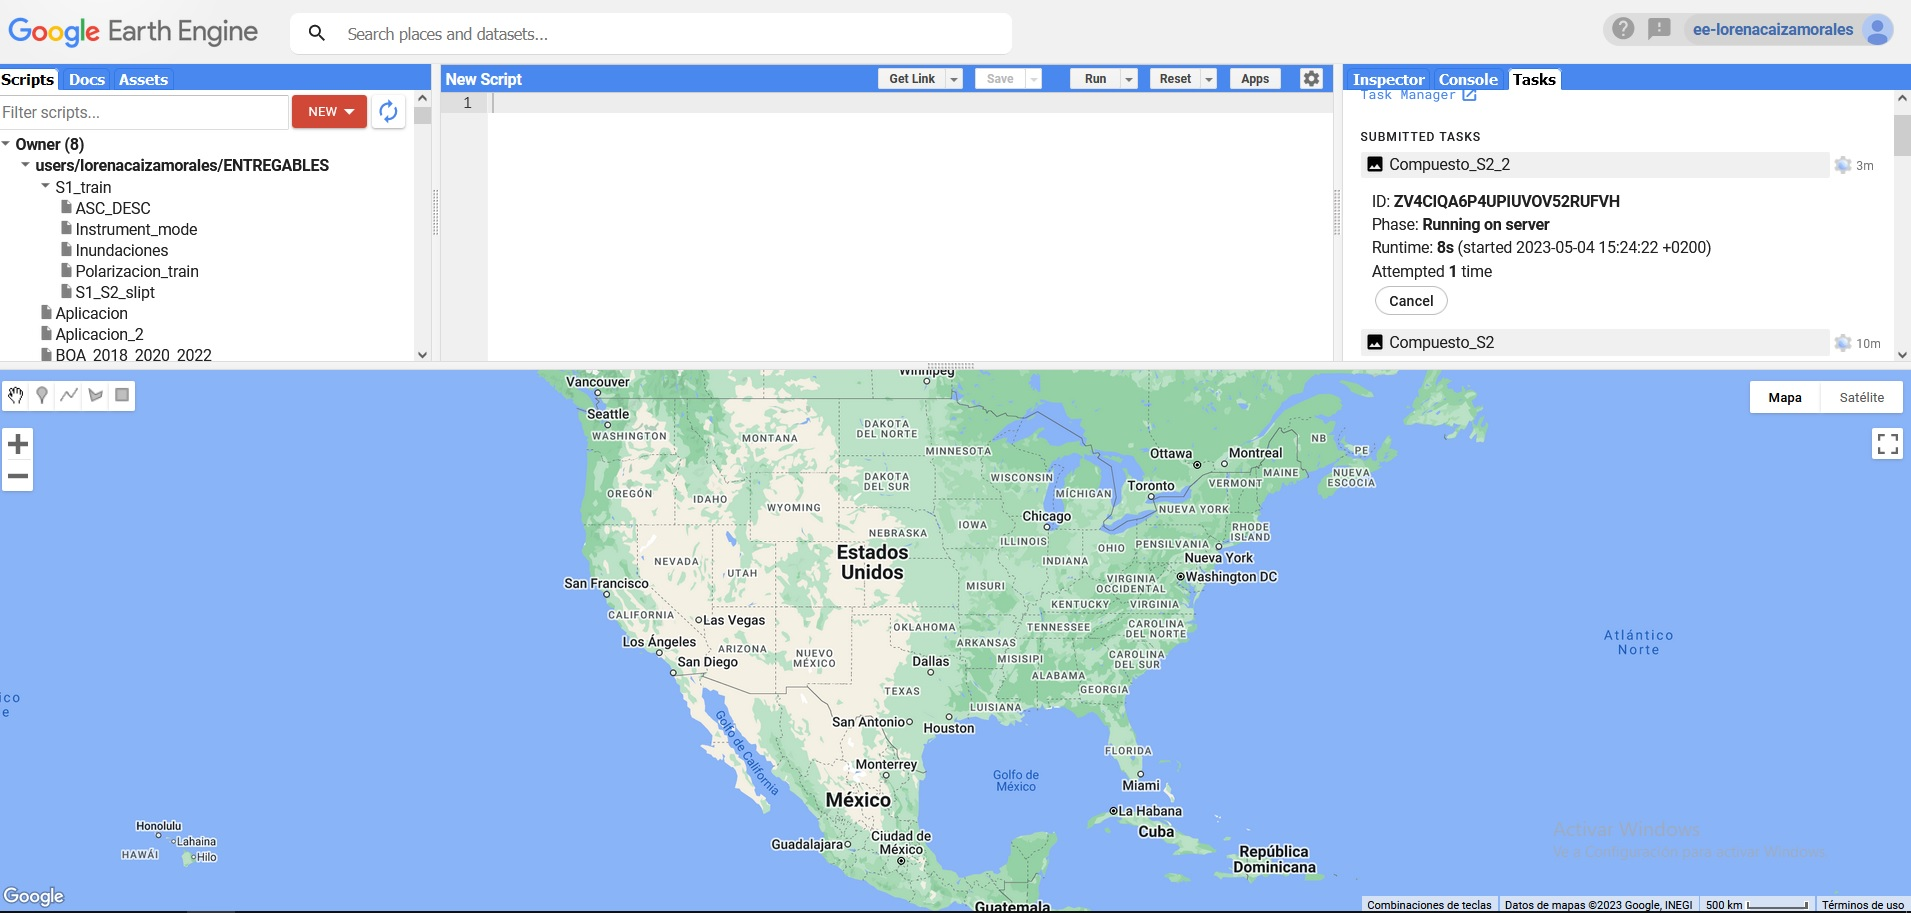


### Obtener el segundo compuesto temporal
*To Obtain the second temporal composite*

Se necesitarán dos mapas de cobertura para la detección de cambios
Puede crear el compuesto del periodo de comparación en los siguientes comandos

*Two mangrove map will require to obtain change maps. You can create the second composite in the following commands*

In [ ]:
##Definir la fecha del segundo año de análisis para filtar los datos S2
START_DATE2= ee.Date('2022-03-01')
END_DATE2= ee.Date('2022-12-31')

In [ ]:
s2_collection = s2_cld(AOI, START_DATE2, END_DATE2)
s2_cl_sh = (s2_water.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).map(addIndexS2))
#Aplica el reductor de mediana
s2_ct2=s2_cl_sh.median()
task = ee.batch.Export.image.toAsset(**{
  'image': s2_ct2,
  'description': 'ESM_2022', #reemplaza el nombre
  'assetId': 'projects/ee-lorenacaizamorales/assets/GRUPO_MANGLEE/ESM_2022', #reemplaza el path de tu carpeta de GEE
  'scale': 10,
  'region': roi.geometry(),
  'maxPixels': 1e10
})
task.start()